# Layer Product Unification Example

https://github.com/layerml/examples/tree/main/product-unification

In this notebook, we are going to analyze the generated entities of Product Unification example.

In [1]:
import layer
import base64
import matplotlib.pyplot as plt
from PIL import Image
from base64 import b64decode
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import io

In [2]:
# You should have a Layer account by now, you can login with:
layer.login()

# 1. Analyze the `Products` Dataset

Products [dataset](https://docs.beta.layer.co/docs/datacatalog/datasets) is the source data which contains the products' image, title and label group. This dataset is introduced in the Layer Data Catalog with [this file](https://github.com/layerml/examples/blob/main/product-unification/data/product_dataset/dataset.yaml). Now, let's fetch it from the [Layer DataCatalog](https://beta.layer.co/features) and analyze it. We can fetch the dataset as a `pandas` or `spark` dataframe.

In [3]:
# Fetch dataset as a Spark Dataframe
df = layer.get_dataset("products").to_spark()
df.show(5)

# Fetch dataset as a Pandas Dataframe
# df = layer.get_dataset("products").to_pandas()
# df.head()

21/08/06 17:39:37 WARN Utils: Your hostname, MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.1.47 instead (on interface en0)
21/08/06 17:39:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/06 17:39:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/06 17:39:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/08/06 17:39:43 WARN SizeEstimator: Failed to check whether UseCompressedOops is set; assuming yes
21/08/06 17:39:48 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(scavenge), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or 

+--------------------+----------------+-----------+--------------------+----------------+--------------------+
|               image|      posting_id|label_group|             content|     image_phash|               title|
+--------------------+----------------+-----------+--------------------+----------------+--------------------+
|9a881896c41fae722...|train_1988115074| 3675037490|/9j/4AAQSkZJRgABA...|9ae560da5097dcb1|Jaket Bb Parka Ab...|
|9aaae058158461a69...|train_1871651657| 2032048970|/9j/4AAQSkZJRgABA...|b430cfcf9238c1e3|Mi Urai Original ...|
|9b16a08ef6cde038f...|train_2992887566| 2825000343|/9j/4AAQSkZJRgABA...|fa3d8b0bf0c097d0|STRIP AUTOCHECK C...|
|9c21ee2d185b68732...| train_789292603| 2470288007|/9j/4AAQSkZJRgABA...|f2c865f34c10df54|Lifree extra sera...|
|9eedca1ad4c4b397c...|train_1189296939| 4032500581|/9j/4AAQSkZJRgABA...|faf0950381abca97|Kertas HVS Merk P...|
+--------------------+----------------+-----------+--------------------+----------------+--------------------+
o

# 2. Analyze the Calculated Features

We can also fetch the calculated features from Layer Data Catalog. For example, [product_similarity_features](https://github.com/layerml/examples/tree/main/product-unification/data/product_similarity_features) is a complex set of features which holds the image and title similarity scores of two different products. It uses the image and title vectors from [another feature](https://github.com/layerml/examples/blob/main/product-unification/data/product_features/image_vector/feature.py). Let's see if Layer was able to calculate it right.

In [4]:
psf = layer.get_featureset("product_similarity_features").to_spark()
psf.show(5)

+----------------+----------------+-------------------+----------------+
|      posting_id|    posting_id_2|   image_similarity|title_similarity|
+----------------+----------------+-------------------+----------------+
|train_1027977874|train_1316267241| 0.1406711559549294|             0.0|
|train_1027977874| train_133048496| 0.1318540762496989|             0.0|
|train_1027977874| train_133493955|0.12933721376234356|             0.0|
|train_1027977874|train_1498915620|0.16342646559492927|             0.0|
|train_1027977874|train_1431505272|0.09322664409899788|             0.0|
+----------------+----------------+-------------------+----------------+
only showing top 5 rows



In [5]:
spf = psf.filter(psf.image_similarity <=.90).orderBy("image_similarity", ascending=False).limit(10)

spf = spf.join(df, spf.posting_id == df.posting_id) \
        .select(spf.posting_id,spf.posting_id_2,f.col("content").alias("image_1")) \
        .join(df, spf.posting_id_2 == df.posting_id) \
        .select(spf.posting_id,spf.posting_id_2,f.col("image_1"), f.col("content").alias("image_2"))

spf.show()

+----------------+----------------+--------------------+--------------------+
|      posting_id|    posting_id_2|             image_1|             image_2|
+----------------+----------------+--------------------+--------------------+
|train_2247784747|train_2848561396|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_2717189631|train_3048288001|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_2713364875|train_3590941606|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_2717189631| train_362500243|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_3048288001| train_362500243|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_1601991592|train_3680569832|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_3680569832|train_3957743951|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_3728093344| train_433462825|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_2531151627| train_837157045|/9j/4AAQSkZJRgABA...|/9j/4AAQSkZJRgABA...|
|train_3794135548| train_837157045|/9j/4AAQSkZJRgABA...|/9j/4AAQ

In [6]:
def convert_string_to_image(content):
    return Image.open(io.BytesIO(b64decode(content)))

images = []
for row in spf.take(10):
    images.append(convert_string_to_image(row["image_1"]))
    images.append(convert_string_to_image(row["image_2"]))

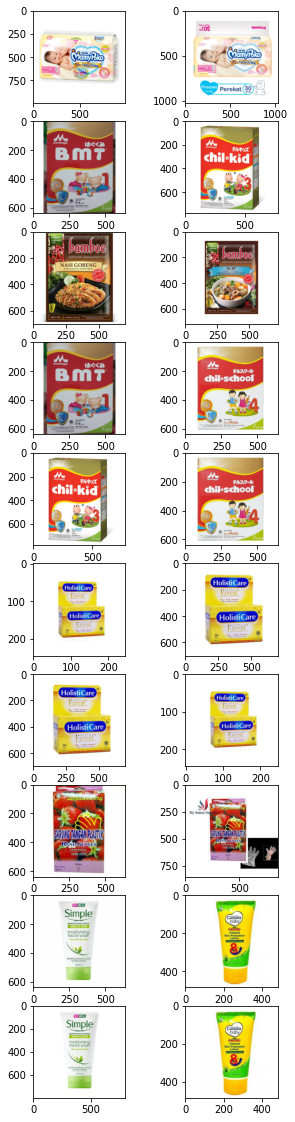

In [7]:
plt.figure(figsize=(5,20))

for i in range(20):
    plt.subplot(10,2,i+1)
    plt.imshow(images[i])

plt.show()